
Best Threshold (F1-optimized): 0.3861

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84      1033
           1       0.56      0.71      0.62       374

    accuracy                           0.77      1407
   macro avg       0.72      0.75      0.73      1407
weighted avg       0.80      0.77      0.78      1407

Accuracy: 0.774
ROC AUC Score: 0.8201


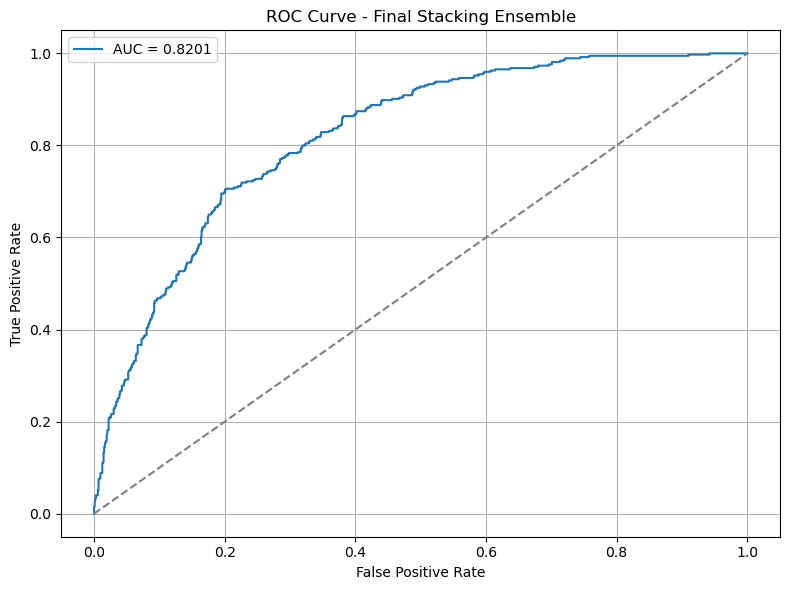

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_curve, roc_curve
from imblearn.over_sampling import SMOTE
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# [2] Load and preprocess
df = pd.read_csv("../data/Telecom Customers Churn.csv")
df.drop("customerID", axis=1, inplace=True)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

for col in df.select_dtypes(include="object").columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop("Churn", axis=1)
y = df["Churn"]

# [3] Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# [4] Base Learners
logreg = LogisticRegression(solver='lbfgs', max_iter=2000, class_weight='balanced')
logreg_cv = RandomizedSearchCV(logreg, {'C': np.linspace(0.1, 2.0, 10)}, n_iter=5, scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
logreg_cv.fit(X_train_scaled, y_train_res)

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}
rf_cv = RandomizedSearchCV(rf, rf_params, n_iter=5, scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
rf_cv.fit(X_train_scaled, y_train_res)

scale_pos_weight = (y_train_res == 0).sum() / (y_train_res == 1).sum()
xgb = XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight)
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_cv = RandomizedSearchCV(xgb, xgb_params, n_iter=5, scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
xgb_cv.fit(X_train_scaled, y_train_res)

# ANN
def create_ann_model(neurons=64, learning_rate=0.001, dropout_rate=0.3, hidden_layers=2):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    for _ in range(hidden_layers):
        model.add(Dense(neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['AUC'])
    return model

ann = KerasClassifier(model=create_ann_model, verbose=0)
ann_params = {
    'model__neurons': [64, 128],
    'model__learning_rate': [0.0005, 0.001],
    'model__dropout_rate': [0.2, 0.3],
    'model__hidden_layers': [2, 3],
    'batch_size': [32, 64],
    'epochs': [40, 60]
}
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
sample_weights = np.where(y_train_res == 1, 2.0, 1.0)
ann_cv = RandomizedSearchCV(estimator=ann, param_distributions=ann_params, n_iter=10,
                            scoring='roc_auc', cv=5, random_state=42, verbose=0, n_jobs=1)
ann_cv.fit(X_train_scaled, y_train_res, sample_weight=sample_weights,
           callbacks=[early_stopping], validation_split=0.1)
best_ann = ann_cv.best_estimator_

# [5] Meta-learner tuning
gb_meta = GradientBoostingClassifier(random_state=42)
meta_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}
meta_cv = RandomizedSearchCV(gb_meta, meta_params, n_iter=5, scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
meta_cv.fit(X_train_scaled, y_train_res)

# [6] Final Ensemble
stacking_model = StackingClassifier(
    estimators=[
        ('logreg', logreg_cv.best_estimator_),
        ('rf', rf_cv.best_estimator_),
        ('xgb', xgb_cv.best_estimator_),
        ('ann', best_ann)
    ],
    final_estimator=meta_cv.best_estimator_,
    passthrough=True,
    n_jobs=-1
)
stacking_model.fit(X_train_scaled, y_train_res)

# [7] Threshold Tuning & Evaluation
y_proba = stacking_model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
precision, recall = precision[:-1], recall[:-1]
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1)
best_thresh = thresholds[best_idx]
y_pred = (y_proba >= best_thresh).astype(int)

print("\nBest Threshold (F1-optimized):", round(best_thresh, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_proba), 4))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Final Stacking Ensemble")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
